<a href="https://colab.research.google.com/github/meliksahb/501-DeepLearning/blob/main/CENG_501_A_bare_bones_object_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a bare-bones object detector

This is intended for those who have absolutely no idea about how object detection is done under the hood.

[Emre Akbas](http://user.ceng.metu.edu.tr/~emre/)

v1: Nov 2019

v2: updated Nov 2020

In [1]:
# Download the dataset
!git clone https://github.com/Tony607/mmdetection_object_detection_demo.git
!mv mmdetection_object_detection_demo/data .
!rm -rf mmdetection_object_detection_demo

Cloning into 'mmdetection_object_detection_demo'...
remote: Enumerating objects: 101, done.
remote: Total 101 (delta 0), reused 0 (delta 0), pack-reused 101 (from 1)
Receiving objects: 100% (101/101), 6.07 MiB | 6.23 MiB/s, done.
Resolving deltas: 100% (41/41), done.


In [2]:
# PASCAL VOC parser is needed to read and parse the dataset
!pip install python_voc_parser  # installs https://github.com/gabrielrezzonico/python_voc_parser

import python_voc_parser as voc
train_parser = voc.VocAnnotationsParser('data/VOC2007/JPEGImages/','data/VOC2007/ImageSets/Main/trainval.txt','data/VOC2007/Annotations/')
test_parser  = voc.VocAnnotationsParser('data/VOC2007/JPEGImages/','data/VOC2007/ImageSets/Main/test.txt','data/VOC2007/Annotations/')

  Preparing metadata (setup.py) ... done
  Created wheel for python_voc_parser: filename=python_voc_parser-1.0.0-py3-none-any.whl size=5201 sha256=abdda9f15b5be4df61804c18eaeeb9bebf24442f9aae899eed89fa1564da4b1d
  Stored in directory: /root/.cache/pip/wheels/06/56/a1/725fbcaa0ed812289671dd88d7b1395b2e117ace69e28eb602
Successfully built python_voc_parser


In [3]:
annotations = train_parser.get_annotation_dataframe_compact()
print(annotations)
print("bounding boxes in the first image: \n" + str(annotations.iloc[0][0]))

                                                                                     annon
img_full_path                                                                             
/content/data/VOC2007/JPEGImages/0.jpg   (((101, 117, 240, 286), date), ((322, 321, 463...
/content/data/VOC2007/JPEGImages/1.jpg   (((390, 61, 513, 196), fig), ((266, 17, 352, 9...
/content/data/VOC2007/JPEGImages/11.jpg  (((564, 208, 708, 382), date), ((499, 352, 609...
/content/data/VOC2007/JPEGImages/12.jpg  (((125, 205, 243, 375), date), ((230, 223, 355...
/content/data/VOC2007/JPEGImages/13.jpg  (((248, 30, 431, 170), date), ((398, 175, 587,...
/content/data/VOC2007/JPEGImages/14.jpg  (((317, 124, 426, 274), date), ((455, 136, 568...
/content/data/VOC2007/JPEGImages/16.jpg  (((145, 198, 259, 377), date), ((490, 215, 611...
/content/data/VOC2007/JPEGImages/17.jpg  (((332, 6, 431, 160), fig), ((269, 341, 415, 5...
/content/data/VOC2007/JPEGImages/2.jpg   (((234, 73, 447, 209), date), ((523, 172, 729,...

/tmp/ipython-input-1946921098.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("bounding boxes in the first image: \n" + str(annotations.iloc[0][0]))


In [4]:
# Let's write a function that shows object bounding boxes on an image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

def show_boxes(im, annotations):
  # Create figure and axes
  fig,ax = plt.subplots(1)

  # Display the image
  ax.imshow(im)

  for i in range(len(annotations)):
    box,clsname = annotations[i]
    rect = patches.Rectangle(box[:2], box[2]-box[0]+1, box[3]-box[1]+1,
        linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    ax.text(box[0], box[1], clsname, color='white', size='larger',
            bbox=dict(facecolor='red', alpha=0.8))

  plt.axis('off')
  plt.show()


# a small adjustment for visualization
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [13, 13]

/content/data/VOC2007/JPEGImages/6.jpg


/tmp/ipython-input-3112966746.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  show_boxes(im, data[0])


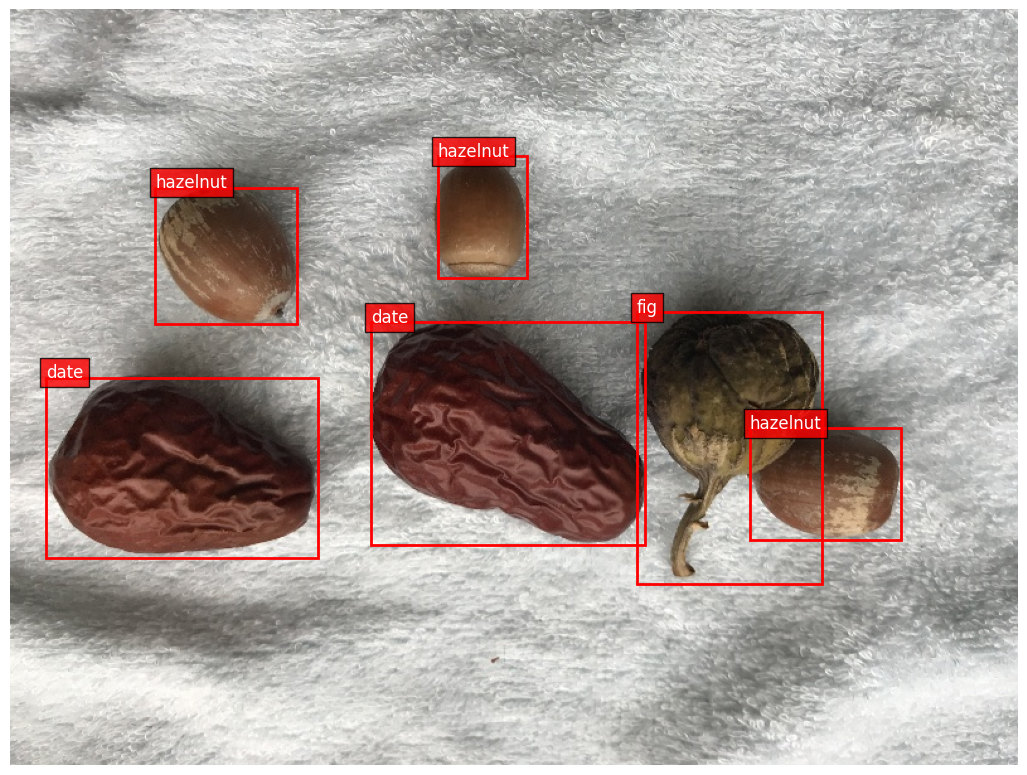

In [5]:
# Show bounding boxes on a randomly selected training image

id = np.random.randint(len(annotations))

data = annotations.iloc[id]
print(data.name)
im = Image.open(data.name)
show_boxes(im, data[0])

In [6]:
# Define a CNN model
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 7)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 7)
        self.conv3 = nn.Conv2d(16, 32, 7)
        self.conv4 = nn.Conv2d(32, 64, 7)
        self.conv5 = nn.Conv2d(64, 64, 7)
        self.class_branch = nn.Conv2d(64, num_classes, 1)
        self.reg_branch = nn.Conv2d(64, 4, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        cls = self.class_branch(x)
        reg = self.reg_branch(x)
        return cls, reg

num_classes = 4    # 4 classes (1 for background)
net = Net(num_classes).to(device)

In [7]:
# PyTorch networks expect tensors of size N*C*H*W
# N: batch size
# C: channel size
# H: height
# W: width

# ToTensor() transformation "moves" the channel dimension before height, width
from torchvision import transforms
preprocess = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])   # normalization
])

In [8]:
# Now, randomly choose a training image and run the CNN network on it
id = np.random.randint(len(annotations))
data = annotations.iloc[id]
print(data.name)
im = Image.open(data.name)

imT = preprocess(im)
print(np.min(imT.numpy()), np.max(imT.numpy()), np.mean(imT.numpy()))
print(imT.shape)
batch = imT[np.newaxis, :].to(device) # This makes a batch from a single image
print(batch.shape)
cls_out, box_out = net(batch)

print(cls_out.shape, box_out.shape)

/content/data/VOC2007/JPEGImages/6.jpg
-2.0182073 2.64 0.7648763
torch.Size([3, 600, 800])
torch.Size([1, 3, 600, 800])
torch.Size([1, 4, 12, 19]) torch.Size([1, 4, 12, 19])


/tmp/ipython-input-3876216461.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels,reg_targets = construct_labels(data[0], (im.size[1], im.size[0]), cls_out.shape[2:4])


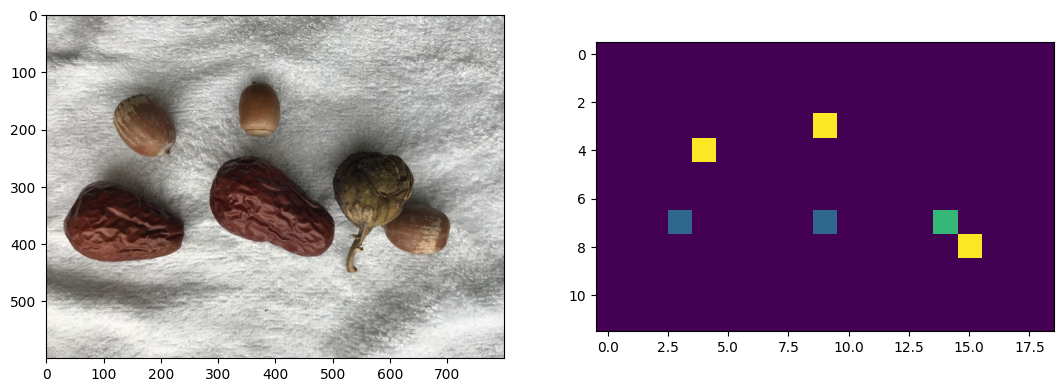

In [9]:
# Prepare the ground-truth label maps
def construct_labels(box_data, imsize, network_out_size):
  labels = np.zeros(network_out_size)
  rel_box_coords = -1*np.ones((network_out_size[0], network_out_size[1], 4))

  for i in range(len(box_data)):
    box_coords = box_data[i][0]
    cls_name   = box_data[i][1]

    # find the center location of the box
    center_x = 0.5*(box_coords[2]-box_coords[0]) + box_coords[0]
    center_y = 0.5*(box_coords[3]-box_coords[1]) + box_coords[1]

    # find the closest location in the network's output
    scaling_x = labels.shape[1]/imsize[1]
    normalized_center_x = center_x*scaling_x
    scaling_y = labels.shape[0]/imsize[0]
    normalized_center_y = center_y*scaling_y
    ny = int(round(normalized_center_y))
    nx = int(round(normalized_center_x))

    rel_box_coords[ny,nx,:] = [(box_coords[3]-box_coords[1]+1)*scaling_y,
                           (box_coords[2]-box_coords[0]+1)*scaling_x,
                           normalized_center_x - nx,
                           normalized_center_y - ny]

    if cls_name=='date':
      labels[ny][nx] = 1

    if cls_name=='fig':
      labels[ny][nx] = 2

    if cls_name=='hazelnut':
      labels[ny][nx] = 3

  return labels, rel_box_coords

labels,reg_targets = construct_labels(data[0], (im.size[1], im.size[0]), cls_out.shape[2:4])

plt.subplot(1,2,1).imshow(im)
plt.subplot(1,2,2).imshow(labels)

We are now ready to train our network.

In [10]:
labels = torch.from_numpy(labels).long().view(-1)
print(labels.shape)

torch.Size([228])


In [11]:
print(cls_out.shape)
cls_out = cls_out.squeeze().permute(1,2,0).view(-1,num_classes)
print(cls_out.shape)

torch.Size([1, 4, 12, 19])
torch.Size([228, 4])


In [12]:
print(box_out.shape)
box_out = box_out.squeeze().permute(1,2,0).view(-1,4)
reg_targets = torch.from_numpy(reg_targets).view(-1,4)
print(box_out.shape)

torch.Size([1, 4, 12, 19])
torch.Size([228, 4])


In [13]:
reg_targets[labels>0,:]
box_out[labels>0,:]

tensor([[ 0.1136, -0.0799, -0.0256, -0.1059],
        [ 0.1018, -0.0591, -0.0286, -0.1217],
        [ 0.1132, -0.0702, -0.0192, -0.0999],
        [ 0.1182, -0.0900, -0.0187, -0.1105],
        [ 0.1128, -0.0822, -0.0216, -0.1152],
        [ 0.1055, -0.0723, -0.0247, -0.1208]], device='cuda:0',
       grad_fn=<IndexBackward0>)

In [14]:
# Define the loss function
criterion = nn.CrossEntropyLoss()


In [15]:
# Training

net = Net(num_classes).to(device)

softmax_CE = nn.CrossEntropyLoss(weight=torch.Tensor([0.1,.3,.3,.3]).to(device))
mse = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)#, weight_decay=1.e-1)

# optimization loop
for epoch in range(200):
  running_loss = 0.0
  for iter in range(len(annotations)):
    optimizer.zero_grad()

    # choose a training image randomly
    id = np.random.randint(len(annotations))

    # grab this image's details (filename, box annotations)
    data = annotations.iloc[id]

    # read the image
    im = Image.open(data.name)

    # convert to PyTorch tensor with a batch size of 1
    imT = preprocess(im)
    batch = imT[np.newaxis, :].to(device)

    # run the CNN on the image
    cls_out, box_out = net(batch)

    # obtain ground-truth label map and box (regression) targets
    labels, reg_targets = construct_labels(data[0], (im.size[1], im.size[0]), cls_out.shape[2:4])

    # kutu etiketlerini ve network ciktisini uygun boyutlara getir
    labels = torch.from_numpy(labels).long().view(-1)
    cls_out = cls_out.squeeze().permute(1,2,0).view(-1,num_classes)

    # kutu koordinatlarini uygun boyutlara getir
    reg_targets = torch.from_numpy(reg_targets).float().view(-1, 4)
    reg_targets = reg_targets[labels>0,:]
    box_out = box_out.squeeze().permute(1,2,0).view(-1,4)
    box_out = box_out[labels>0,:]

    # compute loss and gradient
    loss = softmax_CE(cls_out, labels.to(device)) + mse(box_out, reg_targets.to(device))
    running_loss += loss.item()
    loss.backward()

    # gradient descent update
    optimizer.step()

  print('[Epoch %d] loss: %.3f' % (epoch + 1, running_loss/len(annotations)))

/tmp/ipython-input-2270593901.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels, reg_targets = construct_labels(data[0], (im.size[1], im.size[0]), cls_out.shape[2:4])


[Epoch 1] loss: 2.094
[Epoch 2] loss: 0.987
[Epoch 3] loss: 1.113
[Epoch 4] loss: 0.882
[Epoch 5] loss: 1.081
[Epoch 6] loss: 1.087
[Epoch 7] loss: 0.877
[Epoch 8] loss: 0.810
[Epoch 9] loss: 0.851
[Epoch 10] loss: 0.869
[Epoch 11] loss: 0.754
[Epoch 12] loss: 0.871
[Epoch 13] loss: 0.975
[Epoch 14] loss: 0.924
[Epoch 15] loss: 0.819
[Epoch 16] loss: 0.815
[Epoch 17] loss: 0.749
[Epoch 18] loss: 0.772
[Epoch 19] loss: 0.832
[Epoch 20] loss: 0.788
[Epoch 21] loss: 0.798
[Epoch 22] loss: 0.716
[Epoch 23] loss: 0.850
[Epoch 24] loss: 1.076
[Epoch 25] loss: 0.957
[Epoch 26] loss: 0.805
[Epoch 27] loss: 0.780
[Epoch 28] loss: 0.848
[Epoch 29] loss: 0.732
[Epoch 30] loss: 0.833
[Epoch 31] loss: 0.741
[Epoch 32] loss: 0.872
[Epoch 33] loss: 0.750
[Epoch 34] loss: 0.825
[Epoch 35] loss: 0.759
[Epoch 36] loss: 0.848
[Epoch 37] loss: 0.755
[Epoch 38] loss: 0.725
[Epoch 39] loss: 0.719
[Epoch 40] loss: 0.820
[Epoch 41] loss: 0.640
[Epoch 42] loss: 0.694
[Epoch 43] loss: 0.818
[Epoch 44] loss: 0.6

/content/data/VOC2007/JPEGImages/11.jpg
torch.Size([3, 600, 800])
torch.Size([1, 3, 600, 800])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


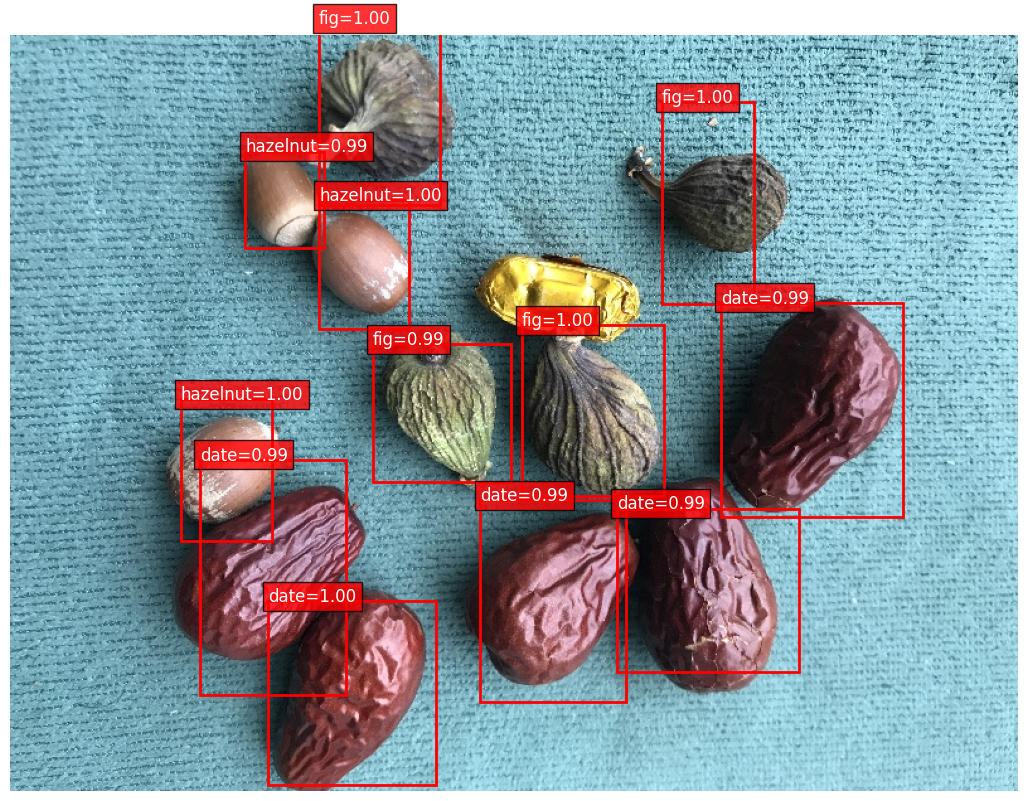

In [16]:
# Run the trained network on an image

id = np.random.randint(len(annotations))
data = annotations.iloc[id]
print(data.name)
im = Image.open(data.name)

imT = preprocess(im)
print(imT.shape)
batch = imT[np.newaxis, :].to(device)
print(batch.shape)
cls_out, box_out = net(batch)

T = .2

def show_detector_output(im, cls_out, box_out, T=0.2):
  boxes = []
  smax = nn.Softmax()
  for y in range(cls_out.shape[2]):
    for x in range(cls_out.shape[3]):
      cls_probs = smax(cls_out[0,:,y,x]).cpu().detach().numpy()

      if not np.any(cls_probs>=T):
        continue

      w,h,delx,dely = box_out[0,:,y,x].cpu().detach().numpy()

      scaling_y = batch.shape[2]/cls_out.shape[2]#).numpy()
      scaling_x = batch.shape[3]/cls_out.shape[3]#).numpy()
      x0 = (x+delx-w/2)*scaling_x
      y0 = (y+dely-h/2)*scaling_y
      x1 = (x+delx+w/2)*scaling_x
      y1 = (y+dely+h/2)*scaling_y

      if cls_probs[1]>=T:
        boxes.append(((x0,y0,x1,y1),'date=%.2f' % cls_probs[1]))

      if cls_probs[2]>=T:
        boxes.append(((x0,y0,x1,y1),'fig=%.2f' % cls_probs[2]))

      if cls_probs[3]>=T:
        boxes.append(((x0,y0,x1,y1),'hazelnut=%.2f' %cls_probs[3]))

  show_boxes(im, tuple(boxes))

show_detector_output(im, cls_out, box_out)

/content/data/VOC2007/JPEGImages/10.jpg
torch.Size([3, 600, 800])
torch.Size([1, 3, 600, 800])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


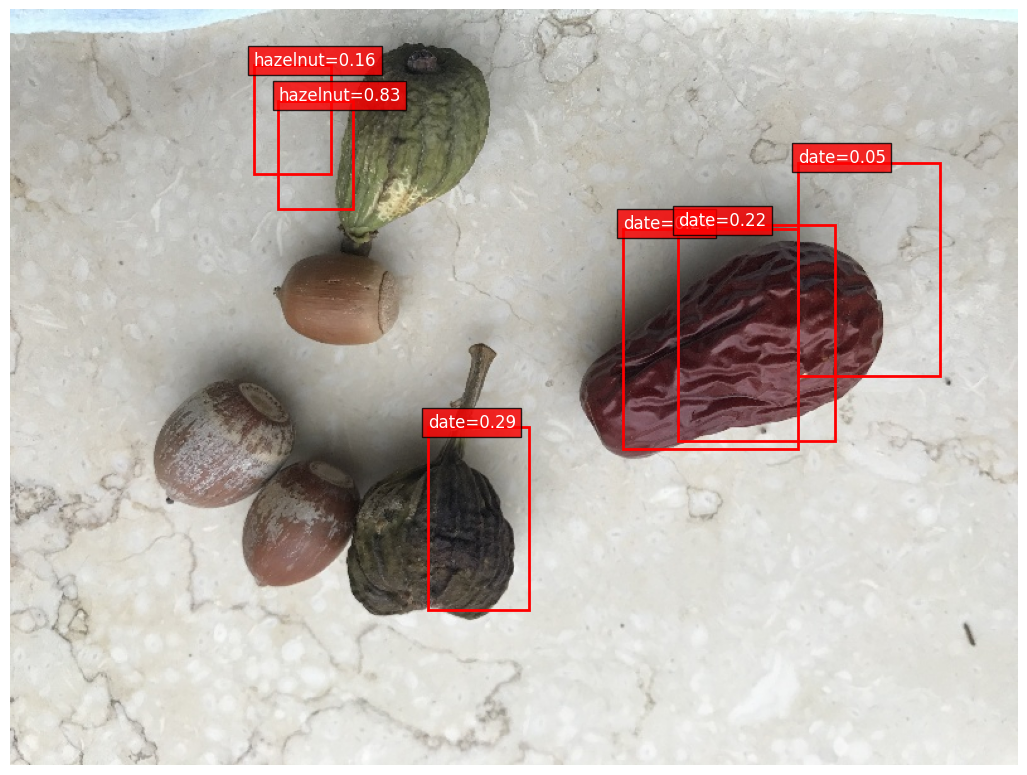

In [17]:
test_annotations = test_parser.get_annotation_dataframe_compact()

# Run the trained network on a test image
id = 0#np.random.randint(len(test_annotations))
data = test_annotations.iloc[id]
print(data.name)
im = Image.open(data.name)

imT = preprocess(im)
print(imT.shape)
batch = imT[np.newaxis, :].to(device)
print(batch.shape)
cls_out,box_out = net(batch)

show_detector_output(im, cls_out, box_out, T=0.05)

# Points/directions to improve

1. Better feature extraction (we used a very simple/shallow network)
2. Larger dataset (we only used 15 images for training)
2. Do "data augmentation" (we did not do it)
3. Handling imbalance between positive and negative examples (we used the simplest method, there are much better (more complicated) ones)
4. Bounding box regression (We used $L_2$ loss, there are much better losses)
5. Handling the "scale imbalance" (we did not do anything about this)
6. Labeling objects (we represented objects as points, there are many other methods)
7. ...